In [6]:
import json
import os
import pickle
import sys
from glob import glob

with open('../utils/dirs.json', 'r') as f:
    dirs = json.load(f)
sys.path.append(dirs['root'])

import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler as rus
from matplotlib import pyplot as plt
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter1d as smooth
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm

from utils.prompts import select_region, select_subject
from utils.pyplotutils import plotLDA

data_path = dirs['data']
out_path  = dirs['out']['dec']

subjects = []
for subject in glob(os.path.join(data_path, 'mat-*.mat')):
    name = '-'.join(os.path.basename(subject).split('.')[0].split('-')[1:3])
    subjects.append(name)

with open(os.path.join('/Codes/eeg-categorical-representation/utils', 'channels.pkl'), 'rb') as fp:
    chInfo = pickle.load(fp)      

with open(os.path.join('/Codes/eeg-categorical-representation/utils', 'info.pkl'), 'rb') as fp:
    info = pickle.load(fp)

# subjectIndices = select_subject(subjects)

In [ ]:
def plotLDA(subject, cm, region, time, sigma=5, fig_path='.'):
    acc = np.diagonal(cm, axis1=2, axis2=3).sum(2) / cm.sum((2, 3)) * 100
    recall = np.diagonal(cm, axis1=2, axis2=3) / cm.sum(3) * 100

    fig, axs = plt.subplots(1, 2, figsize=(14, 4), sharey=False)

    acc = smooth(acc, sigma=sigma)
    axs[0].plot(time, acc.mean(0), lw=3)
    axs[0].fill_between(time,
                     acc.mean(0) - acc.std(0),
                     acc.mean(0) + acc.std(0),
                     alpha=.1, label='_nolegend_')
    axs[0].set_title('Accuracy', fontsize=14)

    for icat in np.arange(4):
        r = smooth(recall[:, :, icat], sigma=sigma, axis=-1)
        axs[1].plot(time, r.mean(0), lw=3)
        axs[1].fill_between(time,
                         r.mean(0) - r.std(0),
                         r.mean(0) + r.std(0),
                         alpha=.1, label='_nolegend_')
    axs[1].set_xlim(-50, 500)    
    axs[1].legend(['Face', 'Body', 'Artificial', 'Natural'], frameon=False)
    axs[1].set_title('Recall', fontsize=14)

    sns.despine()
    for ax in axs:
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.axvline(0, c='gray', ls='--', label='_nolegend_')
        ax.axhline(25, c='gray', ls='--', label='_nolegend_')
        ax.axvline(170, c='gray', ls='--', label='_nolegend_')
        ax.set_xlim(-50, 500)
        # ax.set_ylim(0, 100)
    
    fig.suptitle(f"LDA Performance on Subject: {subject.replace('-', ' ').capitalize().title()} - {region.capitalize()}", fontsize=20)
    fig.tight_layout()
    plt.savefig(os.path.join(fig_path, subject, f'lda-{region}.jpg'), dpi=600)

In [7]:
subjects

['ali-jaami',
 'amirali-soltani',
 'armin-taherifard',
 'azadeh-barimani',
 'hosein-tondro',
 'kaveh-alipanahi',
 'maryam-karimi',
 'milad-yekani',
 'mohammadrasoul-parsaian',
 'ramin-toosi',
 'sana-etemadi',
 'sepehr-sima',
 'zahra-salimi']

In [8]:
d = loadmat(os.path.join(data_path, f'mat-{subjects[6]}.mat'))
# time = d['time'].flatten()[np.arange(0, d['X'].shape[2] - 50)] * 1000 + 25
time = np.arange(0, d['X'].shape[2] - 50, 1) * 2 + 25 - 500

In [9]:
time = d['time'].flatten()[np.arange(0, d['time'].size - 5)] + 2.5 * 0.002

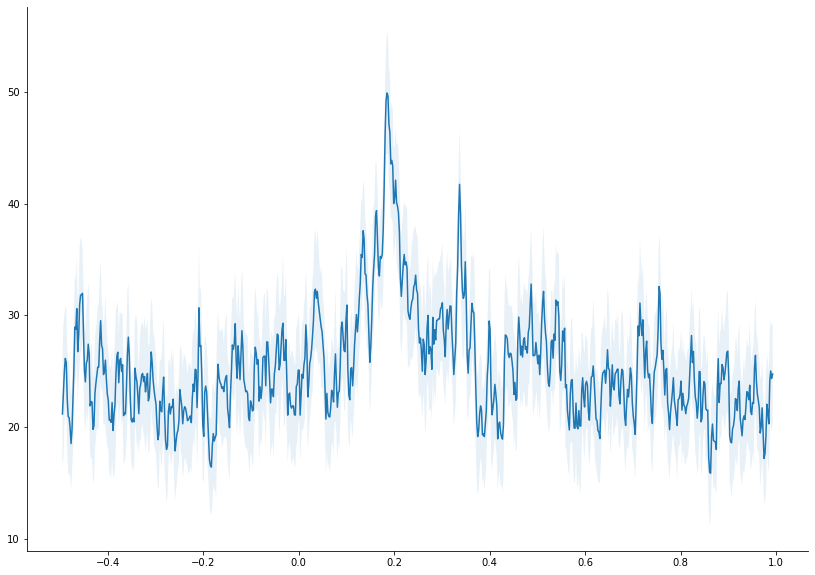

In [16]:
out_path  = r'G:\Codes\cr-eeg\dec\Subjects'
subjectPaths = glob(os.path.join(out_path, '*'))

subjectIndices = [0] #np.arange(12)
# fig, axs = plt.subplots(4, 3, figsize=(14, 10), sharey=False)
fig, axs = plt.subplots(1, 1, figsize=(14, 10), sharey=False)
axs = [axs]
# axs = axs.flatten()

tmp = []
for i, index in enumerate(subjectIndices):
    subject = subjects[index]
    cm = np.load(os.path.join(subjectPaths[index], f'confusion-matrix-{"occipital"}.npy'))
    acc = (np.diagonal(cm, axis1=3, axis2=4).sum(3) / cm.sum((3, 4)) * 100).mean(1)
    
    
    axs[i].plot(time, acc.mean(0))
    axs[i].fill_between(time,
                     acc.mean(0) - acc.std(0),
                     acc.mean(0) + acc.std(0),
                     alpha=.1, label='_nolegend_');
    
    tmp.append(acc.mean(0))
tmp = np.array(tmp)
sns.despine()

# tmp = []
# for i, index in enumerate(subjectIndices):
#     subject = subjects[index]
#     cm = np.load(os.path.join(out_path, subject, f'confusion-matrix-{"occipital"}.npy'))
#     acc = (np.diagonal(cm, axis1=3, axis2=4).sum(3) / cm.sum((3, 4)) * 100).mean(1)
    
    
#     axs[i].plot(time, acc.mean(0))
#     axs[i].fill_between(time,
#                      acc.mean(0) - acc.std(0),
#                      acc.mean(0) + acc.std(0),
#                      alpha=.1, label='_nolegend_');
    
#     tmp.append(acc.mean(0))
# tmp = np.array(tmp)
# sns.despine()

In [113]:
out_path  = r'G:\Codes\cr-eeg\dec\Subjects'

subjectIndices = np.arange(12)
# fig, axs = plt.subplots(4, 3, figsize=(14, 10), sharey=False)
# axs = axs.flatten()

occ, tmp, frn = [], [], [];
for i, index in enumerate(subjectIndices):
    subject = subjects[index]
    cm = np.load(os.path.join(out_path, subject, f'confusion-matrix-{"occipital"}.npy'))
    acc = (np.diagonal(cm, axis1=3, axis2=4).sum(3) / cm.sum((3, 4)) * 100).mean(1)
    occ.append(acc.mean(0))
    
    cm = np.load(os.path.join(out_path, subject, f'confusion-matrix-{"temporal"}.npy'))
    acc = (np.diagonal(cm, axis1=3, axis2=4).sum(3) / cm.sum((3, 4)) * 100).mean(1)
    tmp.append(acc.mean(0))
    
    cm = np.load(os.path.join(out_path, subject, f'confusion-matrix-{"frontal"}.npy'))
    acc = (np.diagonal(cm, axis1=3, axis2=4).sum(3) / cm.sum((3, 4)) * 100).mean(1)
    frn.append(acc.mean(0))
    
#     axs[i].plot(time, acc.mean(0))
#     axs[i].fill_between(time,
#                      acc.mean(0) - acc.std(0),
#                      acc.mean(0) + acc.std(0),
#                      alpha=.1, label='_nolegend_');
    
    
occ = np.array(occ)
tmp = np.array(tmp)
frn = np.array(frn)

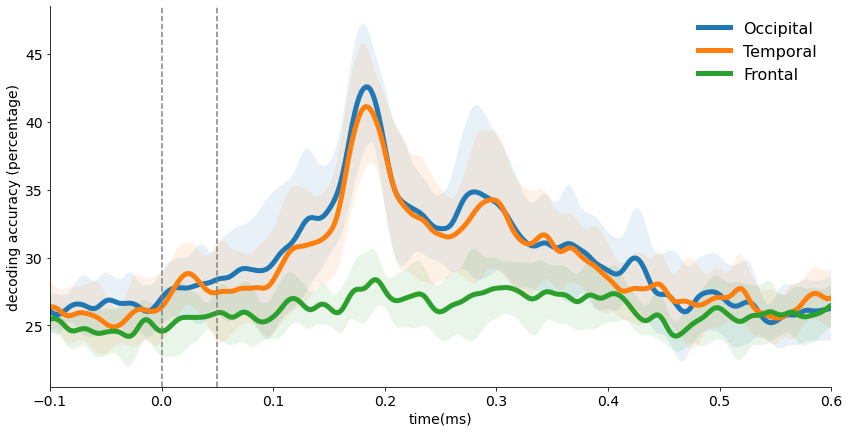

In [148]:
fig, axs = plt.subplots(1, 1, figsize=(14, 7), sharey=False)

xxx = smooth(occ, 3)
plt.plot(time, xxx.mean(0), lw=5)
plt.fill_between(time,
                 xxx.mean(0) - xxx.std(0),
                 xxx.mean(0) + xxx.std(0),
                 alpha=.1, label='_nolegend_');

xxx = smooth(tmp, 3)
plt.plot(time, xxx.mean(0), lw=5)
plt.fill_between(time,
                 xxx.mean(0) - xxx.std(0),
                 xxx.mean(0) + xxx.std(0),
                 alpha=.1, label='_nolegend_');

xxx = smooth(frn, 3)
plt.plot(time, xxx.mean(0), lw=5)
plt.fill_between(time,
                 xxx.mean(0) - xxx.std(0),
                 xxx.mean(0) + xxx.std(0),
                 alpha=.1, label='_nolegend_');


plt.axvline(0, c='gray', ls='--')
plt.axvline(0.05, c='gray', ls='--')
plt.xlim([-0.1, 0.6])
plt.legend(["Occipital", "Temporal", "Frontal"], frameon=False, fontsize=16)
plt.xlabel("time(ms)", fontsize=14)
plt.ylabel("decoding accuracy (percentage)", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)    
sns.despine()

plt.savefig("visual.png", dpi=600)

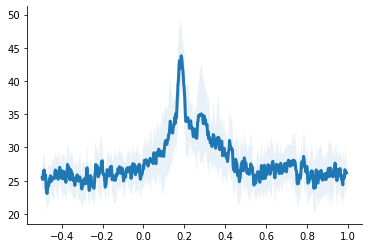

In [104]:
plt.plot(time, tmp.mean(0), lw=3)
plt.fill_between(time,
                    tmp.mean(0) - tmp.std(0),
                    tmp.mean(0) + tmp.std(0),
                    alpha=.1, label='_nolegend_');
sns.despine()

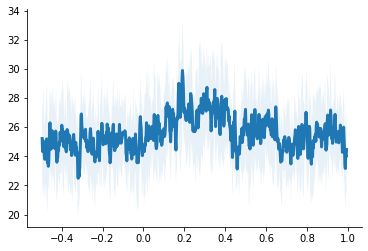

In [111]:
plt.plot(time, tmp.mean(0), lw=3)
plt.fill_between(time,
                    tmp.mean(0) - tmp.std(0),
                    tmp.mean(0) + tmp.std(0),
                    alpha=.1, label='_nolegend_');
sns.despine()

In [63]:


# dirs = {
#     'data': 'G:/Data/EEG', 
#     'out': {
#         'dec': 'G:/Codes/cr-eeg/dec/Subjects',
#         'frq': 'G:/Codes/cr-eeg/dec/Subjects'
#     }
# }

# with open('dirs.json', 'w', encoding='utf-8') as f:
#     json.dump(dirs, f, ensure_ascii=False, indent=4)

'G:/Data/EEG'